In [1]:
## This is demo for kuka reaching a desired point with diff_qp
## Author : Avadesh Meduri
## Date : 25/02/2022
import time
import numpy as np
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

from diff_pin_costs import DiffFK
from inverse_qp import IOC

import torch
from torch.autograd import Function
from torch.nn import functional as F

In [2]:
robot = IiwaConfig.buildRobotWrapper()
model, data = robot.model, robot.data
f_id = model.getFrameId("EE")

/opt/openrobots/lib/python3.8/site-packages/pinocchio/shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


In [3]:
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
dfk = DiffFK.apply
def quadratic_loss(q_pred, x_des, nq):
    return torch.linalg.norm(dfk(q_pred[-2*nq:], model, data, f_id) - x_des)

In [28]:
nq = model.nq
nv = model.nv
q0 = [np.pi/16.0, -np.pi/16.0, 0, 0, 0, 0, 0]
x_init = np.concatenate([q0, pin.utils.zero(model.nv)])

n_col = 10
u_max = model.nq*[400,]

lr = 1e-2
eps = 80

In [104]:
buffer_size = 50
x_train_init = np.tile(x_init, (buffer_size,1))
x_train_des = torch.zeros((buffer_size, 3))

n_vars = 3*nq*n_col + 2*nq
y_train = torch.zeros((buffer_size, n_vars**2 + n_vars))

In [105]:
for k in range(buffer_size):
    ioc = IOC(n_col, nq, u_max, 0.05, eps = 1.0, isvec=False)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr)

    q_des = np.hstack(((np.pi/8)*np.random.randint(-4,4, size=4), np.zeros(3)))
    dq_des = np.zeros_like(q_des)

    pin.forwardKinematics(model, data, q_des, dq_des, np.zeros(nv))
    pin.updateFramePlacements(model, data)

    x_des = torch.tensor(data.oMf[f_id].translation)
    x_train_des[k] = x_des
    
    for i in range(eps):

        x_pred = ioc(x_init) 

        loss = quadratic_loss(x_pred, x_des, nq)
        print("Index :" + str(k) + " loss is : " + str(loss.detach().numpy()), end = '\r', flush = True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # storing the weights and x_nom
    y_train[k] = torch.hstack((ioc.weight.flatten(), ioc.x_nom))

In [106]:
x_train = x_train_des.float()
y_train = y_train.detach().float()

In [118]:
class Net(torch.nn.Module):

    def __init__(self, inp_size, out_size):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        
        self.fc1 = torch.nn.Linear(inp_size, 120)
        self.out = torch.nn.Linear(120, out_size)

    def forward(self, x):
       
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [155]:
nn = Net(x_train.shape[1], y_train.shape[1])

lr = 1e-2
eps = 1500
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
loss = torch.nn.MSELoss()

for i in range(eps):
    
    y_pred = nn(x_train)
    error = loss(y_pred, y_train) 
    print("The iteration number : " str(i) + " The loss is :" + str(error.detach().numpy()), end='\r')
    optimizer.zero_grad()
    error.backward()
    optimizer.step()

In [219]:
x_des = x_train[np.random.randint(buffer_size)]
pred = nn(x_des)

ioc.weight = torch.nn.Parameter(torch.reshape(pred[0:n_vars**2], (n_vars, n_vars)))
ioc.x_nom = torch.nn.Parameter(pred[n_vars**2:])

x_pred = ioc(x_init) 
x_pred = x_pred.detach().numpy()

viz.viewer["box"].set_object(g.Sphere(0.05), 
                         g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
viz.viewer["box"].set_transform(tf.translation_matrix(x_des.detach().numpy()))


plt_des = np.zeros((n_col+1, 3))

for i in range(n_col+1):
    q = x_pred[3*nq*i:3*nq*i + nq]
    dq = np.zeros_like(q_des)

    pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
    pin.updateFramePlacements(model, data)
    
    plt_des[i] = data.oMf[f_id].translation

    viz.display(q)
    time.sleep(0.05)

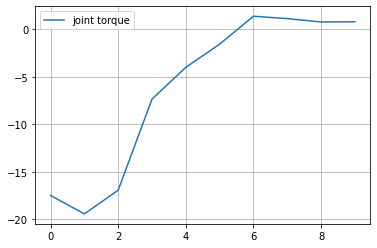

In [205]:
from matplotlib import pyplot as plt

plt.plot(x_pred[2*nq + 1:: 3*nq], label = "joint torque")
plt.legend()
plt.grid()

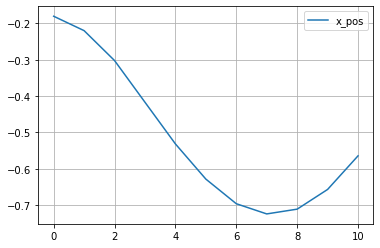

In [199]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,0], label = "x_pos")
plt.grid()
plt.legend()

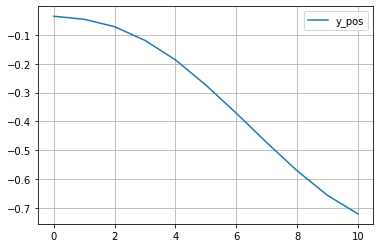

In [202]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,1], label = "y_pos")
plt.grid()
plt.legend()

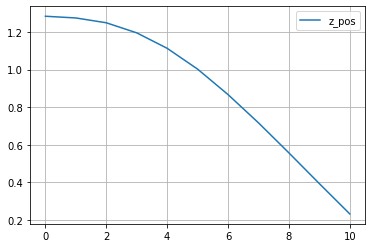

In [204]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,2], label = "z_pos")
plt.grid()
plt.legend()